# EFT Fisher at z=0.5: full P(k,μ) method

## Set up the notebook

In [1]:
# Import the science packages/libraries
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy, scipy.interpolate, scipy.misc, scipy.integrate

import os.path as op
import matplotlib.pyplot as plt

In [2]:
# Set plotting and printing

%matplotlib inline

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

np.set_printoptions(precision=3,linewidth=200,suppress=False)

from matplotlib.patches import Ellipse

In [3]:
# Main question for the Fisher matrix calculation: which parameters are we varying?
# Note that this list determines the order in the output FM as well

#NB: the cs0, cs2, cs4 params here are actually the cs squared (like in the MCMC)
varypars = ['b','b2','N','cs0','cs2','cs4','f']

## Set up the fiducial model for the Fisher matrix calculation

In [4]:
#k values are the same in all files ### Paths to input files
PATHTOINPUTFILES = op.abspath('./inputs/')

# Function to read the output files from MG-COPTER
def read_copter(path,suffix=''):
    
    #naming files (following the Mathematica notebook)
    psfile = ('eft_ps_components_nw'+suffix+'.dat')
    abcfile = ('eft_abc_components'+suffix+'.dat')
    biasfile = ('eft_bias_components'+suffix+'.dat')
    
    # set the names of the columns (following the Mathematica notebook)
    pscolnames = 'k', 'pl', 'pdd', 'pdt', 'ptt', 'sv', 'plnw', 'pddres', 'pdtres', 'pttres','ANW'
    abccolnames = 'k', 'bu2f2nw', 'bu2f3nw', 'bu4f2nw', 'bu4f3nw', 'bu6f3nw', 'b2u2f1nw', 'b2u2f2nw', 'b2u2f3nw',\
    'b2u2f4nw', 'b2u4f2nw', 'b2u4f3nw', 'b2u4f4nw', 'b2u6f3nw', 'b2u6f4nw', 'b2u8f4nw', 'u2f4nw', 'u4f3nw', 'u4f4nw',\
    'u6f3nw', 'u6f4nw', 'u8f4nw' 
    biascolnames = 'k', 'ddb0b2nw', 'ddb02nw', 'ddb0nw', 'ddb22nw', 'ddb2nw', 'ddnonenw', 'dtb2nw', 'dtb0nw', 'dtnonenw'
    
    return np.genfromtxt(op.join(path,psfile), names=pscolnames),\
           np.genfromtxt(op.join(path,abcfile), names=abccolnames),\
           np.genfromtxt(op.join(path,biasfile), names=biascolnames)

# use numpy to read the whole files, the options will make the
# resulting object act a bit like a dictionary (a structured array)
# so we can query columns by name
ps_fid, abc_fid, bias_fid = read_copter(op.join(PATHTOINPUTFILES,'data_fid'),'_fid')
print ('ps column names:', ps_fid.dtype.names )# let's print the names to check
print ('abc column names:', abc_fid.dtype.names) # let's print the names to check
print ('bias column names:', bias_fid.dtype.names) # let's print the names to check

ps column names: ('k', 'pl', 'pdd', 'pdt', 'ptt', 'sv', 'plnw', 'pddres', 'pdtres', 'pttres', 'ANW')
abc column names: ('k', 'bu2f2nw', 'bu2f3nw', 'bu4f2nw', 'bu4f3nw', 'bu6f3nw', 'b2u2f1nw', 'b2u2f2nw', 'b2u2f3nw', 'b2u2f4nw', 'b2u4f2nw', 'b2u4f3nw', 'b2u4f4nw', 'b2u6f3nw', 'b2u6f4nw', 'b2u8f4nw', 'u2f4nw', 'u4f3nw', 'u4f4nw', 'u6f3nw', 'u6f4nw', 'u8f4nw')
bias column names: ('k', 'ddb0b2nw', 'ddb02nw', 'ddb0nw', 'ddb22nw', 'ddb2nw', 'ddnonenw', 'dtb2nw', 'dtb0nw', 'dtnonenw')


In [5]:
#Fiducial (GR-COLA) cosmology 
#from cos.rtf file (changed some params names here)

zbin = 0.5

c=3e5
hubble = 0.697
H00 = 100*hubble
Tcmb = 2.726
ns = 0.971
om0 = 0.281
omb = 0.046
sigma80_fid = 0.844 #this is sigma8 at z=0

sv_fid = ps_fid['sv'][0] 
ANW = ps_fid['ANW'][0]

b_fid = 1.471
b2_fid = -0.393
N_fid = 676.0 
#NB: the cs0, cs2, cs4 params here are actually the cs squared (like in the MCMC)
cs0_fid = 2.718
cs2_fid = 23.218
cs4_fid = 19.540

#kmax at z=0.5 
kmax = 0.245

print(sv_fid)
print(ANW)

38.83043
76.11283


## Set up the survey properties

In [6]:
### Set up survey with volume ~4 Gpc^3/h^3
Area = 15000.0*1.06 #deg^2 
Dzbin = 0.2
z_vals = np.array([zbin]) 
Nzbin = len(z_vals)

#set kmin 
kmin = 0.006

In [7]:
#construct array of mu values between -1 and 1 (inclusive)
mu_step = 0.005
mu = mu_step*np.arange((2/mu_step)+1)-1.
#print ('mu array', mu)
#len(mu)

## Define cosmology functions: background and perturbations

In [8]:
# Functions for DE later
def w_integrand(z,w0=-1.,wa=0.):
    return (1 + w0+wa*z/(z+1)) / (1+z)
def DE_evo(zc,w0=-1.,wa=0.): 
    return np.exp(3*scipy.integrate.romberg(lambda z: w_integrand(z,w0,wa), 0, zc))

# Define E(z) = H(z)/H0
def Ez(zc,w0=-1.,wa=0.):
    return np.sqrt((1-om0)*DE_evo(zc,w0,wa) + om0*pow(1+zc,3))

# LCDM growth rate and growth factor
def fg(zz,w0=-1.,wa=0.,gamma=0.55):
    omz=om0*pow(1+zz,3)/pow(Ez(zz,w0,wa),2)
    return pow(omz,gamma)

def Dg_dz(zz,w0=-1.,wa=0.,gamma=0.55):
    return -fg(zz,w0,wa)/(1+zz)

def Dgz(zz,w0=-1.,wa=0.,gamma=0.55):
    start_z = 0.0
    ans = scipy.integrate.romberg(lambda z: Dg_dz(z,w0,wa), start_z, zz)
    return np.exp(ans)

nz = 100
fg_fid_interp = np.zeros(nz)
Dg_fid_interp = np.zeros(nz)
z_for_interp = np.linspace(0,2,nz)
for i,z in enumerate(z_for_interp):
    fg_fid_interp[i] = fg(z)
    Dg_fid_interp[i] = Dgz(z)

fg_fid_i = scipy.interpolate.interp1d(z_for_interp,fg_fid_interp,kind='cubic')
Dg_fid_i = scipy.interpolate.interp1d(z_for_interp,Dg_fid_interp,kind='cubic')
del z_for_interp, Dg_fid_interp, fg_fid_interp, i, z
print (fg_fid_i(zbin), Dg_fid_i(zbin))

0.733197112933542 0.7784487714884997


In [9]:
#Define E(z)=H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))

#Define the comoving distance
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0,zc)
def DA(zc):
    return rcom(zc)/(1+zc)

def Vsur(zc): #  (the hubble**3 factor is for units consistency)
    z_min = zc-Dzbin/2
    DA_min = DA(z_min)
    z_max = zc+Dzbin/2
    DA_max = DA(z_max)
    
    F = (4.*np.pi/3.) / (4.*np.pi*(180./np.pi)**2)   
    return F * (DA_max**3 *(1+z_max)**3 - DA_min**3 *(1+z_min)**3) * hubble**3 * Area

print(round(Vsur(zbin)/1e9,3))

3.994


In [10]:
#construct Peft function
def Peft(mu_array,f,
         b=b_fid,b2=b2_fid,N=N_fid,
         cs0=cs0_fid,cs2=cs2_fid,cs4=cs4_fid,sv=sv_fid,
         sig8_z=sigma80_fid*Dg_fid_i(zbin),
         ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu_array**0.
    k_array = ps['k']
    
    D = sig8_z/sigma80_fid #every term that contains D, contains the same power of sigma80_fid
    
    #resummation part
    pddresum = D**2 * ps['plnw'] + D**4 * ps['pddres']\
    + np.exp(-0.5*ps['k']**2*D**2*ANW) * ( D**2 * ps['pl'] + D**4 * ps['pdd'] - (D**2*ps['plnw'] + D**4*ps['pddres'])\
                                         +0.5*ps['k']**2*D**2*ANW*(D**2*(ps['pl']-ps['plnw'])))
   
    pdtresum = D**2 * f * ps['plnw'] + D**4 * f * ps['pdtres']\
    + np.exp(-0.5*ps['k']**2*D**2*ANW) * ( D**2 * f * ps['pl'] + D**4 * f * ps['pdt'] - (D**2*f*ps['plnw'] + D**4*f*ps['pdtres'])\
                                         +0.5*ps['k']**2*D**2*ANW*(f*D**2*(ps['pl']-ps['plnw'])))
    
    pttresum = D**2 * f**2 * ps['plnw'] + D**4 * f**2 * ps['pttres']\
    + np.exp(-0.5*ps['k']**2*D**2*ANW) * ( D**2 * f**2 * ps['pl'] + D**4 * f**2 * ps['ptt'] - (D**2*f**2*ps['plnw'] + D**4*f**2*ps['pttres'])\
                                         +0.5*ps['k']**2*D**2*ANW*(f**2*D**2*(ps['pl']-ps['plnw'])))
    
    #total power spectrum
    FoG = (1 - f**2*np.outer(k_array**2,mu_array**2)*D**2*sv_fid)\
             
    res = FoG\
    *((b**2*np.outer(pddresum,muones)\
    + D**4*(b*b2*np.outer(bias['ddb0b2nw'],muones) + b**2*np.outer(bias['ddb02nw'],muones)\
    + b*np.outer(bias['ddb0nw'],muones) + b2**2*np.outer(bias['ddb22nw'],muones)\
    + b2*np.outer(bias['ddb2nw'],muones) + np.outer(bias['ddnonenw'],muones)) + N 
    + 2*(b*np.outer(pdtresum,mu_array**2))\
    - 2*D**4*f*(b2*np.outer(bias['dtb2nw'],mu_array**2) + b*np.outer(bias['dtb0nw'],mu_array**2) + np.outer(bias['dtnonenw'],mu_array**2)))\
    + np.outer(pttresum,mu_array**4))\
    + D**4*( b*f**2*np.outer(abc['bu2f2nw'],mu_array**2) + b*f**3*np.outer(abc['bu2f3nw'],mu_array**2)\
    + b*f**2*np.outer(abc['bu4f2nw'],mu_array**4)+b*f**3*np.outer(abc['bu4f3nw'],mu_array**4)\
    + b*f**3*np.outer(abc['bu6f3nw'],mu_array**6)+b**2*f*np.outer(abc['b2u2f1nw'],mu_array**2)\
    + b**2*f**2*np.outer(abc['b2u2f2nw'],mu_array**2)+b**2*f**3*np.outer(abc['b2u2f3nw'],mu_array**2)\
    + b**2*f**4*np.outer(abc['b2u2f4nw'],mu_array**2) + b**2*f**2*np.outer(abc['b2u4f2nw'],mu_array**4)\
    + b**2*f**3*np.outer(abc['b2u4f3nw'],mu_array**4) + b**2*f**4*np.outer(abc['b2u4f4nw'],mu_array**4)\
    + b**2*f**3*np.outer(abc['b2u6f3nw'],mu_array**6) + b**2*f**4*np.outer(abc['b2u6f4nw'],mu_array**6)\
    + b**2*f**4*np.outer(abc['b2u8f4nw'],mu_array**8) + f**4*np.outer(abc['u2f4nw'],mu_array**2)\
    + f**3*np.outer(abc['u4f3nw'],mu_array**4) + f**4*np.outer(abc['u4f4nw'],mu_array**4)\
    + f**3*np.outer(abc['u6f3nw'],mu_array**6) + f**4*np.outer(abc['u6f4nw'],mu_array**6)\
    + f**4*np.outer(abc['u8f4nw'],mu_array**8) )\
    - 2.*D**2*( np.outer(k_array**2*ps['plnw'],muones)*cs0 + np.outer(k_array**2*ps['plnw'],cs2*mu_array**2)\
    + np.outer(k_array**2*ps['plnw'],cs4*mu_array**4) + np.outer(k_array**2*ps['plnw'],muones)\
    *(f**3*cs0 - f**2*cs2 + f*cs4)*mu_array**6)
        
    return res

In [11]:
# Effective volume
nbar = 1e-3 #h^3/Mpc^3
def Veff(mu_array,zc):
    n = nbar
    P = Peft(mu_array,fg_fid_i(zc)) 
    return Vsur(zc) / (P+1./n)**2

## Define how to calculate the derivatives with respect to parameters we wish to vary

In [12]:
#Construct the derivatives wrt the bias and EFT parameters

#choose the step (convergent derivatives)
params_step = 1e-5

#Derivative wrt b
def dPeft_db(mu_array,f,D,b,b2,N,cs0,cs2,cs4,sv,
             ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu**0.
    k_array = ps['k']
    
    P_bp = Peft(mu,fg_fid_i(zbin),b_fid*(1+params_step),b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid) 
    P_bm = Peft(mu,fg_fid_i(zbin),b_fid*(1-params_step),b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid) 
    
    deriv_b = (P_bp - P_bm)/(2*b_fid*params_step)
    
    return deriv_b
    
    
#Derivative wrt b2
def dPeft_db2(mu_array,f,D,b,b2,N,cs0,cs2,cs4,sv,
              ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu**0.
    k_array = ps['k']
    
    P_b2p = Peft(mu,fg_fid_i(zbin),b_fid,b2_fid*(1+params_step),N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid) 
    P_b2m = Peft(mu,fg_fid_i(zbin),b_fid,b2_fid*(1-params_step),N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid) 
    
    deriv_b2 = (P_b2p - P_b2m)/(2*b2_fid*params_step)
    
    
    return deriv_b2

#Derivative wrt N
def dPeft_dN(mu_array,f,D,b,b2,N,cs0,cs2,cs4,sv,
             ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu**0.
    k_array = ps['k']
    
    deriv_N = (1 - f**2*np.outer(k_array**2,mu_array**2)*D**2*sv_fid)
    
    return deriv_N

#Derivative wrt cs0 
def dPeft_dcs0(mu_array,f,D,b,b2,N,cs0,cs2,cs4,sv,
               ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu**0.
    k_array = ps['k']
    
    deriv_cs0 = - 2.*D**2*( np.outer(k_array**2*ps['plnw'],muones) + np.outer(k_array**2*ps['plnw'],muones)*f**3*mu_array**6)
    
    return deriv_cs0

#Derivative wrt cs2
def dPeft_dcs2(mu_array,f,D,b,b2,N,cs0,cs2,cs4,sv,
               ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu**0.
    k_array = ps['k']
    
    deriv_cs2 = - 2.*D**2*( np.outer(k_array**2*ps['plnw'],mu_array**2) - np.outer(k_array**2*ps['plnw'],muones)*f**2*mu_array**6)
        
    return deriv_cs2

#Derivative wrt cs4
def dPeft_dcs4(mu_array,f,D,b,b2,N,cs0,cs2,cs4,sv,
               ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu**0.
    k_array = ps['k']

    deriv_cs4 = - 2.*D**2*( np.outer(k_array**2*ps['plnw'],mu_array**4) + np.outer(k_array**2*ps['plnw'],muones)*f*mu_array**6)
        
    return deriv_cs4

#Derivative wrt f
def dPeft_df(mu_array,f,D,b,b2,N,cs0,cs2,cs4,sv,
              ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu**0.
    k_array = ps['k']
    
    P_fp = Peft(mu,fg_fid_i(zbin)*(1+params_step),b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid) 
    P_fm = Peft(mu,fg_fid_i(zbin)*(1-params_step),b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid) 

    deriv_f = (P_fp - P_fm)/(2*fg_fid_i(zbin)*params_step)
    
    return deriv_f

## Set up the Fisher matrix calculation and run to loop to calculate its elements

In [13]:
#for i in range(1,299):
#    print(ps_fid['k'][i+1]-ps_fid['k'][i])

k_step = ps_fid['k'][6] - ps_fid['k'][5]
dkdmu = k_step*mu_step

# k values range to include in the constraints calculation
k_index = (ps_fid['k']<kmax)*(ps_fid['k']>kmin)

In [14]:
# This dictionary contains all the parameters that can be varied in this code.
derivs = {
    'b'  : lambda z,m: dPeft_db(m,fg_fid_i(z),Dg_fid_i(z),b_fid,b2_fid,N_fid,cs0_fid,cs2_fid,cs4_fid,sv_fid),
    'b2' : lambda z,m: dPeft_db2(m,fg_fid_i(z),Dg_fid_i(z),b_fid,b2_fid,N_fid,cs0_fid,cs2_fid,cs4_fid,sv_fid),
    'N'  : lambda z,m: dPeft_dN(m,fg_fid_i(z),Dg_fid_i(z),b_fid,b2_fid,N_fid,cs0_fid,cs2_fid,cs4_fid,sv_fid),
    'cs0': lambda z,m: dPeft_dcs0(m,fg_fid_i(z),Dg_fid_i(z),b_fid,b2_fid,N_fid,cs0_fid,cs2_fid,cs4_fid,sv_fid),
    'cs2': lambda z,m: dPeft_dcs2(m,fg_fid_i(z),Dg_fid_i(z),b_fid,b2_fid,N_fid,cs0_fid,cs2_fid,cs4_fid,sv_fid),
    'cs4': lambda z,m: dPeft_dcs4(m,fg_fid_i(z),Dg_fid_i(z),b_fid,b2_fid,N_fid,cs0_fid,cs2_fid,cs4_fid,sv_fid),
    'f'  : lambda z,m: dPeft_df(m,fg_fid_i(z),Dg_fid_i(z),b_fid,b2_fid,N_fid,cs0_fid,cs2_fid,cs4_fid,sv_fid)
}
            
# Which should depend on redshift
zdep = 'b','b2','N','cs0','cs2','cs4','f'

# Which ones are independent of redshift and should appear in the FM once (summ over z contributions)
zidep = [i for i in derivs.keys() if i not in zdep]
print (zidep)

[]


In [15]:
# Auxiliary bits needed for Fisher matrix calculation

# Create array of zeros for the final FM
Nzdep = len(set(zdep)&set(varypars))
Npar = len(varypars)
s = Nzdep*Nzbin + (Npar-Nzdep)
Fishermat = np.zeros([s,s])

# Fisher matrix integrand - to be integrated over k and mu arrays
def dF(mu_array,zc):
    k_array = ps_fid['k']
    tmp = deriv_i(mu_array,zc)*deriv_j(mu_array,zc)*Veff(mu_array,zc)
    return (1./(8*np.pi*np.pi))*pow(k_array,2)*tmp.T

In [16]:
#%%time 

# Save the indexing for posterity
fm_index = {'b' :[],'b2':[],'N' :[],'cs0':[],'cs2':[],'cs4':[],'f' :[]}

fm_head = []

# Loop over redshift bins
for iz, zc in enumerate(z_vals):
    
    # First loop over parameters (rows of the FM)
    for i, pi in enumerate(varypars): 
        
        # Calculate row index for the Fisher matrix
        if pi in zdep:
            zind = iz*Nzdep + i
        else:
            zind = Nzbin*Nzdep + (i-Nzdep)
                
        # Set the i derivative in dF to correspond to the row parameter
        def deriv_i(mu_array,zc): return derivs[pi](zc,mu_array)

        # Second loop over parameters (columns of the FM)
        for j, pj in enumerate(varypars):
            
            # Calculate column index for the Fisher matrix
            if pj in zdep:
                zjnd = iz*Nzdep + j
            else:
                zjnd = Nzbin*Nzdep + (j-Nzdep)
            
            # If not done yet, set the j derivative in dF to correspond to the column parameter
            if j>=i:
                
                def deriv_j(mu_array,zc): return derivs[pj](zc,mu_array)
                
                fm = dF(mu,zc)[:,k_index]
                Fishermat[zind,zjnd] += np.sum(np.sum(fm))*dkdmu
            
            # Otherwise just take the symmetric value
            else: 
                Fishermat[zind,zjnd] = Fishermat[zjnd,zind]
        
        # Finally, save the index in the FM (same redshift order as z_vals)
        fm_index[pi].append(zind) # Only doing i, since it is symmetric
        
        # Save also the order of the colmns/rows
        headstr = pi
        if pi in zdep: headstr+='_'+str(zc)
        fm_head.append(headstr)

In [17]:
# Very conservative priors for the "no priors" case
# Just want to ensure your cs2s are not negative etc.

cPriormat = Fishermat*0.
cPrior_errors = {
    'cs0': (cs0_fid/100)*100, 
    'cs2': (cs2_fid/100)*100,
    'cs4': (cs4_fid/100)*100
}
for p in cPrior_errors.keys():
    if p not in varypars: continue
    print (p, 'index', fm_index[p][0])
    cPriormat[fm_index[p][0],fm_index[p][0]] = 1./cPrior_errors[p]**2

priorfactor = 0.0    
    
Fishermat = Fishermat+priorfactor*cPriormat
CovMat = scipy.linalg.pinv(Fishermat)
print ('combined marged',  np.sqrt(np.diag(CovMat)))

print ('\nCorrelation coefficients after adding EFT parameters priors:')
print (CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))

cs0 index 3
cs2 index 4
cs4 index 5
combined marged [3.273e-02 5.824e-01 9.260e+02 1.965e+00 2.617e+00 2.279e+00 2.448e-02]

Correlation coefficients after adding EFT parameters priors:
[[ 1.     0.97  -0.985 -0.098  0.903  0.149 -0.588]
 [ 0.97   1.    -0.972  0.061  0.841  0.055 -0.607]
 [-0.985 -0.972  1.     0.174 -0.931 -0.255  0.483]
 [-0.098  0.061  0.174  1.    -0.439 -0.88  -0.542]
 [ 0.903  0.841 -0.931 -0.439  1.     0.456 -0.27 ]
 [ 0.149  0.055 -0.255 -0.88   0.456  1.     0.68 ]
 [-0.588 -0.607  0.483 -0.542 -0.27   0.68   1.   ]]


## Print out results

In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [19]:
# Create a fiducial value dictionary
fids = {
    'b'  : b_fid*np.ones(Nzbin),   
    'b2' : b2_fid*np.ones(Nzbin),  
    'N'  : N_fid*np.ones(Nzbin),   
    'cs0': cs0_fid*np.ones(Nzbin), 
    'cs2': cs2_fid*np.ones(Nzbin), 
    'cs4': cs4_fid*np.ones(Nzbin), 
    'f'  : fg_fid_i(z_vals)
}

In [20]:
print ('Order of columns/rows:')
print (fm_head)
#print 'Fisher matrix:\n',
#print Fishermat

# Invert the Fisher matrix to get the parameter covariance
CovMat = np.linalg.inv(Fishermat)
print ('\nCorrelation matrix for parameters:\n', )
print (CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))

print ('\nCorrelation matrix diagonal:\n', )
print( np.diag(CovMat))

Order of columns/rows:
['b_0.5', 'b2_0.5', 'N_0.5', 'cs0_0.5', 'cs2_0.5', 'cs4_0.5', 'f_0.5']

Correlation matrix for parameters:

[[ 1.     0.97  -0.985 -0.098  0.903  0.149 -0.588]
 [ 0.97   1.    -0.972  0.061  0.841  0.055 -0.607]
 [-0.985 -0.972  1.     0.174 -0.931 -0.255  0.483]
 [-0.098  0.061  0.174  1.    -0.439 -0.88  -0.542]
 [ 0.903  0.841 -0.931 -0.439  1.     0.456 -0.27 ]
 [ 0.149  0.055 -0.255 -0.88   0.456  1.     0.68 ]
 [-0.588 -0.607  0.483 -0.542 -0.27   0.68   1.   ]]

Correlation matrix diagonal:

[1.071e-03 3.391e-01 8.574e+05 3.862e+00 6.849e+00 5.193e+00 5.991e-04]


In [21]:
#np.matmul(Fishermat,CovMat)

In [22]:
# Print the errors nicely
Nvar  = len(varypars)

varyshape = list(set(zidep)&set(varypars))
if len(varyshape)>0:
    shapeind = [fm_index[p][0] for p in varyshape]
    shapefid = np.array([fids[p] for p in varyshape])
    print ('\nvarying shape = \n\t', varyshape)
    print ('shape fiducials = \n\t', shapefid)
    print ('unmarged err = \n\t', np.sqrt(1./np.diag(Fishermat))[shapeind])
    print ('marged err = \n\t', np.sqrt(np.diag(CovMat))[shapeind])
    print ('unmarged % err = \n\t', np.sqrt(1./np.diag(Fishermat))[shapeind]/np.abs(shapefid)*100)
    print ('marged % err = \n\t', np.sqrt(np.diag(CovMat))[shapeind]/np.abs(shapefid)*100)

#varyzdep = list(set(varypars)&set(zdep))
varyzdep = varypars

zdepfid = np.array([fids[p] for p in varyzdep])
print ('\nvarying zdep = \n\t', varyzdep)
if len(varyzdep)>0:
    for iz, z in enumerate(z_vals):
        zdepind = np.array([fm_index[p] for p in varyzdep])
        print ('at z =',z,': zdep fiducials = \n\t', zdepfid[:,iz])
        merrs = np.sqrt(np.diag(CovMat))[zdepind[:,iz]]
        print ('at z =',z,': marged err = \n\t', merrs)
        uerrs = np.sqrt(1./np.diag(Fishermat))[zdepind[:,iz]]
        print ('at z =',z,': unmarged err = \n\t', uerrs)
        print ('at z =',z,': marged % err = \n\t', merrs/np.abs(zdepfid[:,iz])*100.)
        print ('at z =',z,': unmarged % err = \n\t', uerrs/np.abs(zdepfid[:,iz])*100.)


varying zdep = 
	 ['b', 'b2', 'N', 'cs0', 'cs2', 'cs4', 'f']
at z = 0.5 : zdep fiducials = 
	 [ 1.471e+00 -3.930e-01  6.760e+02  2.718e+00  2.322e+01  1.954e+01  7.332e-01]
at z = 0.5 : marged err = 
	 [3.273e-02 5.824e-01 9.260e+02 1.965e+00 2.617e+00 2.279e+00 2.448e-02]
at z = 0.5 : unmarged err = 
	 [1.109e-03 5.981e-03 8.136e+00 6.765e-02 2.389e-01 1.558e-01 1.815e-03]
at z = 0.5 : marged % err = 
	 [  2.225 148.182 136.975  72.307  11.272  11.662   3.338]
at z = 0.5 : unmarged % err = 
	 [0.075 1.522 1.204 2.489 1.029 0.797 0.248]


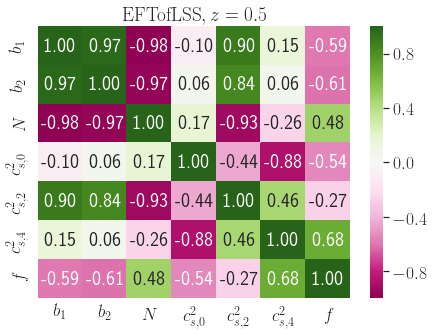

In [23]:
import pandas as pd
import seaborn as sns; sns.set()
sns.set(font_scale=1.6)

fig = plt.figure(figsize=(7,5))
df = pd.DataFrame(CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))
df.rename(columns={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
df.rename(index={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
ax = sns.heatmap(df, cmap="PiYG", vmin=-1, vmax=1, annot = True, fmt='.2f')

ax.set_title('$\mathrm{EFTofLSS}, z=0.5$')
#plt.savefig('corr-mat-eft-zeq0p5.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

In [24]:
df

,$b_1$,$b_2$,$N$,"$c^2_{s,0}$","$c^2_{s,2}$","$c^2_{s,4}$",$f$
$b_1$,1.000000,0.970448,-0.984994,-0.097940,0.902749,0.149178,-0.587712
$b_2$,0.970448,1.000000,-0.971925,0.060683,0.840675,0.055401,-0.607203
$N$,-0.984994,-0.971925,1.000000,0.173853,-0.931434,-0.255080,0.483129
"$c^2_{s,0}$",-0.097940,0.060683,0.173853,1.000000,-0.439409,-0.879713,-0.541544
"$c^2_{s,2}$",0.902749,0.840675,-0.931434,-0.439409,1.000000,0.456002,-0.270229
"$c^2_{s,4}$",0.149178,0.055401,-0.255080,-0.879713,0.456002,1.000000,0.679678
$f$,-0.587712,-0.607203,0.483129,-0.541544,-0.270229,0.679678,1.000000


## Add Gaussian priors on parameters.

In [25]:
# Play with priors on nuisance parameters
EFTmat = Fishermat*0.
EFT_errors = {
#    'cs0': (cs0_fid/100)*10, 
#    'cs2': (cs2_fid/100)*10,
#    'cs4': (cs4_fid/100)*10,
    'b'  : (b_fid/100)*10,
    'N' : (N_fid/100)*10
}
for p in EFT_errors.keys():
    if p not in varyzdep: continue
    print (p, 'index', fm_index[p][0])
    EFTmat[fm_index[p][0],fm_index[p][0]] = 1./EFT_errors[p]**2

Fishermat_comb = Fishermat+EFTmat
CovMat_comb = scipy.linalg.pinv(Fishermat_comb)
print ('combined marged',  np.sqrt(np.diag(CovMat_comb)))

print ('\nCorrelation coefficients after adding EFT parameters priors:')
print (CovMat_comb/np.sqrt(np.outer(np.diag(CovMat_comb),np.diag(CovMat_comb))))

b index 0
N index 2
combined marged [6.111e-03 1.431e-01 6.741e+01 1.935e+00 9.688e-01 2.203e+00 2.144e-02]

Correlation coefficients after adding EFT parameters priors:
[[ 1.     0.396 -0.383  0.393 -0.142 -0.557 -0.698]
 [ 0.396  1.    -0.288  0.945 -0.658 -0.805 -0.651]
 [-0.383 -0.288  1.     0.013 -0.183 -0.02   0.04 ]
 [ 0.393  0.945  0.013  1.    -0.763 -0.877 -0.724]
 [-0.142 -0.658 -0.183 -0.763  1.     0.614  0.547]
 [-0.557 -0.805 -0.02  -0.877  0.614  1.     0.947]
 [-0.698 -0.651  0.04  -0.724  0.547  0.947  1.   ]]


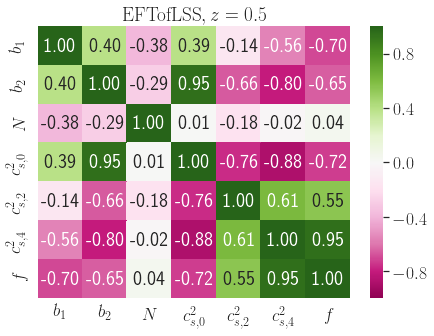

In [26]:
import pandas as pd
import seaborn as sns; sns.set()
sns.set(font_scale=1.6)

fig = plt.figure(figsize=(7,5))
df = pd.DataFrame(CovMat_comb/np.sqrt(np.outer(np.diag(CovMat_comb),np.diag(CovMat_comb))))
df.rename(columns={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
df.rename(index={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
ax = sns.heatmap(df, cmap="PiYG", vmin=-1, vmax=1, annot = True, fmt='.2f')

ax.set_title('$\mathrm{EFTofLSS}, z=0.5$')
#plt.savefig('corr-mat-eft-priors-zeq0p5.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

In [27]:
#df

In [28]:
# Print the errors nicely
Nvar  = len(varypars)

#varyzdep = list(set(varypars)&set(zdep))
varyzdep = varypars

zdepfid = np.array([fids[p] for p in varyzdep])
print ('\nvarying zdep = \n\t', varyzdep)
if len(varyzdep)>0:
    for iz, z in enumerate(z_vals):
        zdepind = np.array([fm_index[p] for p in varyzdep])
        print ('at z =',z,': zdep fiducials = \n\t', zdepfid[:,iz])
        merrs = np.sqrt(np.diag(CovMat_comb))[zdepind[:,iz]]
        print ('at z =',z,': marged err = \n\t', merrs)
        uerrs = np.sqrt(1./np.diag(Fishermat_comb))[zdepind[:,iz]]
        print ('at z =',z,': unmarged err = \n\t', uerrs)
        print ('at z =',z,': marged % err = \n\t', merrs/np.abs(zdepfid[:,iz])*100.)
        print ('at z =',z,': unmarged % err = \n\t', uerrs/np.abs(zdepfid[:,iz])*100.)


varying zdep = 
	 ['b', 'b2', 'N', 'cs0', 'cs2', 'cs4', 'f']
at z = 0.5 : zdep fiducials = 
	 [ 1.471e+00 -3.930e-01  6.760e+02  2.718e+00  2.322e+01  1.954e+01  7.332e-01]
at z = 0.5 : marged err = 
	 [6.111e-03 1.431e-01 6.741e+01 1.935e+00 9.688e-01 2.203e+00 2.144e-02]
at z = 0.5 : unmarged err = 
	 [1.109e-03 5.981e-03 8.078e+00 6.765e-02 2.389e-01 1.558e-01 1.815e-03]
at z = 0.5 : marged % err = 
	 [ 0.415 36.404  9.972 71.203  4.173 11.275  2.924]
at z = 0.5 : unmarged % err = 
	 [0.075 1.522 1.195 2.489 1.029 0.797 0.248]


## Draw Ellipses

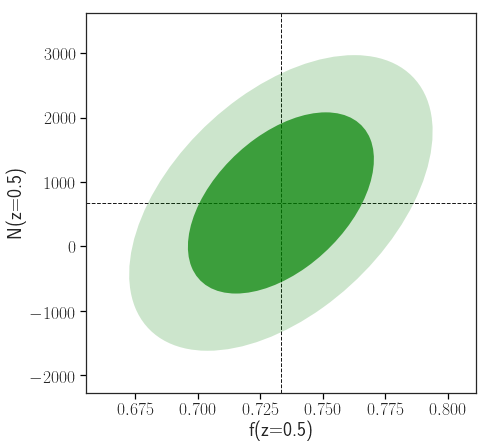

In [29]:
sns.set_style("ticks")

# Choose what to plot
zi = 0; par0 = 'f'; par1 = 'N';

# Get the indices in the Covariance Matrix of the two parameters we want to plot
p0i = varyzdep.index(par0); index0 = zdepind[:,zi] # change this to shapeind if using shape!
p1i = varyzdep.index(par1); index1 = zdepind[:,zi] # change this to shapeind if using shape!

# Get the fiducial values for the ellipse centre
c0 = fids[par0][zi] # remove the [zi] if par0 is a shape parameter!
c1 = fids[par1][zi] # remove the [zi] if par1 is a shape parameter!

# Marginalise out everything else and make a new 2x2 Covariance Matrix
marg_all = True
if marg_all:
    covmat_2D = np.zeros((2,2))
    covmat_2D[0,0] = CovMat[index0[p0i],index0[p0i]]
    covmat_2D[1,1] = CovMat[index1[p1i],index1[p1i]]
    covmat_2D[0,1] = CovMat[index0[p0i],index1[p1i]]
    covmat_2D[1,0] = covmat_2D[0,1]
    
    
else:
    fishmat_2D = np.zeros((2,2))
    fishmat_2D[0,0] = Fishermat[index0[p0i],index0[p0i]]
    fishmat_2D[1,1] = Fishermat[index1[p1i],index1[p1i]]
    fishmat_2D[0,1] = Fishermat[index0[p0i],index1[p1i]]
    fishmat_2D[1,0] = fishmat_2D[0,1]
    covmat_2D = np.linalg.inv(fishmat_2D)
    del fishmat_2D

def get_ellipses(centre,CM_2D):
    # We will need coefficients for the ellipse depending on the number of sigma level we want
    CL_alpha = {
        1: 1.52, 
        2: 2.48,
        3: 3.44
    }

    # Get the errors
    FM_2D = np.linalg.inv(CM_2D)
    em0 = np.sqrt(CM_2D[0,0])
    eu0 = np.sqrt(1./FM_2D[0,0])
    em1 = np.sqrt(CM_2D[1,1])
    eu1 = np.sqrt(1./FM_2D[1,1])

    #print par0, eu0, em0
    #print par1, eu1, em1

    # Now calculate the ellipse parameters
    a = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) + np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    b = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) - np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    theta = 180./np.pi * 0.5*np.arctan(2.*CM_2D[0,1] / (CM_2D[0,0]-CM_2D[1,1])) # should be in degrees

    if CM_2D[0,0]<CM_2D[1,1]:
        width=2.*b
        height=2.*a
    else:
        width=2.*a
        height=2.*b

    # Create all the ellipses
    ellipse1 = Ellipse([centre[0],centre[1]], width*CL_alpha[1], height*CL_alpha[1], theta, 
                       linewidth=0, fill=True, zorder=2, alpha=0.7, color='green')
    ellipse2 = Ellipse([centre[0],centre[1]], width*CL_alpha[2], height*CL_alpha[2], theta, 
                       linewidth=0, fill=True, zorder=2, alpha=0.2, color='green')

    return ellipse1, ellipse2, CL_alpha[1]*em0, CL_alpha[1]*em1, CL_alpha[1]*eu0, CL_alpha[1]*eu1

# Make a test plot
ell1, ell2, errm0, errm1, erru0, erru1 = get_ellipses([c0,c1],covmat_2D)

fig, ax = plt.subplots(figsize=(7,7))

ax.axhline(c1,ls='--',c='k',lw=1); ax.axvline(c0,ls='--',c='k',lw=1) # Centre lines
#ax.axvline(c0-errm0,ls=':',c='g',lw=1); ax.axvline(c0+errm0,ls=':',c='g',lw=1) # Marginalised error lines par0
#ax.axvline(c0-erru0,ls=':',c='c',lw=1); ax.axvline(c0+erru0,ls=':',c='c',lw=1) # Marginalised error lines par0
#ax.axhline(c1-errm1,ls=':',c='g',lw=1); ax.axhline(c1+errm1,ls=':',c='g',lw=1) # Marginalised error lines par1
#ax.axhline(c1-erru1,ls=':',c='c',lw=1); ax.axhline(c1+erru1,ls=':',c='c',lw=1) # Marginalised error lines par1

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.set_xlim(c0-errm0*2.1, c0+errm0*2.1)
ax.set_ylim(c1-errm1*2.1, c1+errm1*2.1)
ax.tick_params(color='black')
ax.set_facecolor('none')
#ax.axis('off')

plt.xlabel(par0+'(z='+str(z_vals[zi])+')')
plt.ylabel(par1+'(z='+str(z_vals[zi])+')')

#plt.savefig('test.png', format="png", bbox_inches = 'tight')
plt.show()

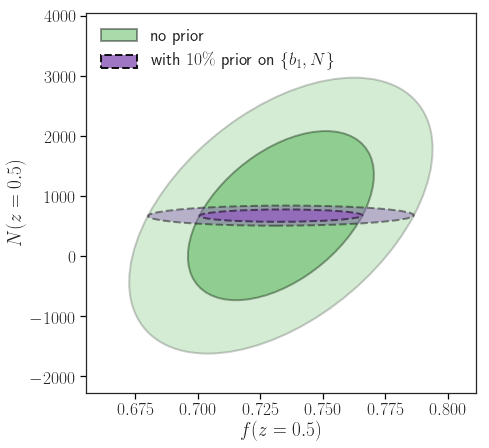

In [30]:
sns.set_style("ticks")

# Choose what to plot
zi = 0; par0 = 'f'; par1 = 'N';

# Get the indices in the Covariance Matrix of the two parameters we want to plot
p0i = varyzdep.index(par0); index0 = zdepind[:,zi] # change this to shapeind if using shape!
p1i = varyzdep.index(par1); index1 = zdepind[:,zi] # change this to shapeind if using shape!

# Get the fiducial values for the ellipse centre
c0 = fids[par0][zi] # remove the [zi] if par0 is a shape parameter!
c1 = fids[par1][zi] # remove the [zi] if par1 is a shape parameter!

# Marginalise out everything else and make a new 2x2 Covariance Matrix
marg_all = True
if marg_all:
    covmat_2D_comb = np.zeros((2,2))
    covmat_2D_comb[0,0] = CovMat_comb[index0[p0i],index0[p0i]]
    covmat_2D_comb[1,1] = CovMat_comb[index1[p1i],index1[p1i]]
    covmat_2D_comb[0,1] = CovMat_comb[index0[p0i],index1[p1i]]
    covmat_2D_comb[1,0] = covmat_2D_comb[0,1]
    
else:
    fishmat_2D_comb = np.zeros((2,2))
    fishmat_2D_comb[0,0] = Fishermat_comb[index0[p0i],index0[p0i]]
    fishmat_2D_comb[1,1] = Fishermat_comb[index1[p1i],index1[p1i]]
    fishmat_2D_comb[0,1] = Fishermat_comb[index0[p0i],index1[p1i]]
    fishmat_2D_comb[1,0] = fishmat_2D_comb[0,1]
    covmat_2D_comb = np.linalg.inv(fishmat_2D_comb)
    del fishmat_2D_comb

def get_ellipses(centre,CM_2D,sty={'w':0,'s':'-','f':True,'a':0.7,'c':'green'}):
    # We will need coefficients for the ellipse depending on the number of sigma level we want
    CL_alpha = {
        1: 1.52, 
        2: 2.48,
        3: 3.44
    }

    # Get the errors
    FM_2D = np.linalg.inv(CM_2D)
    em0 = np.sqrt(CM_2D[0,0])
    eu0 = np.sqrt(1./FM_2D[0,0])
    em1 = np.sqrt(CM_2D[1,1])
    eu1 = np.sqrt(1./FM_2D[1,1])

    #print par0, eu0, em0
    #print par1, eu1, em1

    # Now calculate the ellipse parameters
    a = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) + np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    b = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) - np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    theta = 180./np.pi * 0.5*np.arctan(2.*CM_2D[0,1] / (CM_2D[0,0]-CM_2D[1,1])) # should be in degrees

    if CM_2D[0,0]<CM_2D[1,1]:
        width=2.*b
        height=2.*a
    else:
        width=2.*a
        height=2.*b

    # Create all the ellipses   linestyles = ['-', '--'
    ellipse1 = Ellipse([centre[0],centre[1]], width*CL_alpha[1], height*CL_alpha[1], theta, 
                       linewidth=sty['w'], ls = sty['s'], fill=sty['f'], zorder=2, alpha=sty['a'], color=sty['c'])
    leg1 = ellipse1.set(clip_box=ax.bbox, alpha=sty['a'], facecolor=sty['c'], edgecolor = 'black')
    ellipse2 = Ellipse([centre[0],centre[1]], width*CL_alpha[2], height*CL_alpha[2], theta, 
                       linewidth=sty['w'], ls = sty['s'], fill=sty['f'], zorder=2, alpha=sty['a']/2, color=sty['c'])
    leg2 = ellipse2.set(clip_box=ax.bbox, alpha=sty['a']/2, facecolor=sty['c'], edgecolor = 'black')

    return ellipse1, ellipse2, CL_alpha[1]*em0, CL_alpha[1]*em1, CL_alpha[1]*eu0, CL_alpha[1]*eu1, leg1, leg2

# Make a test plot
ell1, ell2, errm0, errm1, erru0, erru1, leg1, leg2 = get_ellipses([c0,c1],covmat_2D,
                                                    {'w':2,'s':'-','f':True,'a':0.4,'c':'tab:green'}) #without priors
ell1_p, ell2_p, errm0_p, errm1_p, erru0_p, erru1_p, leg1_p, leg2_p = get_ellipses([c0,c1],covmat_2D_comb,
                                                    {'w':2,'s':'--','f':True,'a':0.9,'c':'tab:purple'}) #with priors
ells = [ell1,ell2,ell1_p,ell2_p]
fig, ax = plt.subplots(figsize=(7,7))

#ax.axhline(c1,ls='--',c='k',lw=1); ax.axvline(c0,ls='--',c='k',lw=1) # Centre lines
#ax.axvline(c0-errm0,ls=':',c='g',lw=1); ax.axvline(c0+errm0,ls=':',c='g',lw=1) # Marginalised error lines par0
#ax.axvline(c0-erru0,ls=':',c='c',lw=1); ax.axvline(c0+erru0,ls=':',c='c',lw=1) # Marginalised error lines par0
#ax.axhline(c1-errm1,ls=':',c='g',lw=1); ax.axhline(c1+errm1,ls=':',c='g',lw=1) # Marginalised error lines par1
#ax.axhline(c1-erru1,ls=':',c='c',lw=1); ax.axhline(c1+erru1,ls=':',c='c',lw=1) # Marginalised error lines par1

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ell1_p)
ax.add_artist(ell2_p)
ax.set_xlim(c0-errm0*2.1, c0+errm0*2.1)
ax.set_ylim(c1-errm1*2.1, c1+errm1*2.4)
ax.tick_params(color='black')
ax.set_facecolor('none')
#ax.axis('off')

#plt.xlabel(par0+'(z='+str(z_vals[zi])+')')
#plt.ylabel(par1+'(z='+str(z_vals[zi])+')')
plt.xlabel('$f(z=0.5)$')
plt.ylabel('$N(z=0.5)$')

ax.legend([ell1,ell1_p], [r'no prior',r'with $10\%$ prior on $\{b_1,N\}$'],loc='upper left',frameon=False)

#plt.savefig('contour-EFT-zeq0p5.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

#### Alkistis & Dida, 2019